In [49]:
import sys
sys.path.append('..')
from torchattacks.attacks.mot_bap import MOTBAP
from torchvision import datasets, transforms
import torch
import matplotlib.pyplot as plt
import kornia
import math

import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms, utils
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
from PIL import Image
import json
import cv2
%matplotlib inline

In [50]:
datapath = '/home/zero/zero/split_dp/dataset/imagenet/val'
composers = [
    transforms.Compose([
        transforms.Resize([299, 299]),
        transforms.ToTensor()
    ]),
    transforms.Compose([
        transforms.Resize([299, 299]),
        transforms.ToTensor()
    ])
]
imagenet_val = datasets.ImageFolder(datapath, composers[0])

In [51]:
def plot_tensor(data, title="", figsize=(1, 1), xticks=False, yticks=False):
    b, c, h, w = data.shape

    fig, axes = plt.subplots(1, b, dpi=300, subplot_kw={"aspect": "equal"}, figsize=figsize)
    if b == 1:
        axes = [axes]

    for idx, ax in enumerate(axes):
        ax.imshow(kornia.utils.tensor_to_image(data[idx, ...]))
        ax.set_ylim(h, 0)
        ax.set_xlim(0, w)
        ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
        
        if not xticks:
            ax.set_xticks([])
            
        if not yticks:
            ax.set_yticks([])
    fig.suptitle(title)
    plt.show()

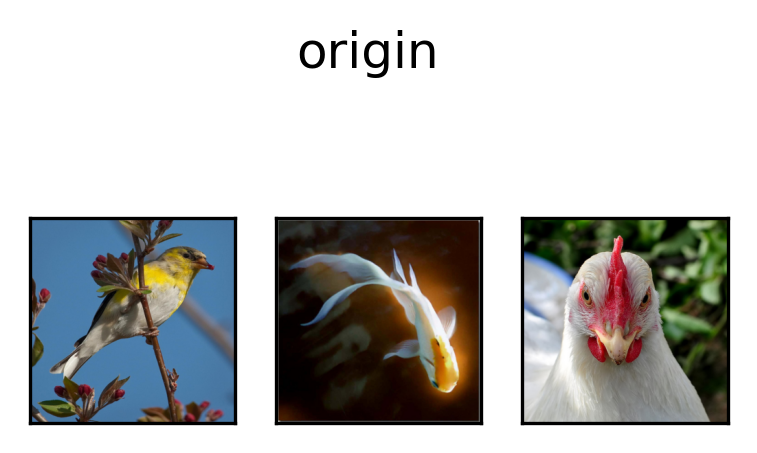

In [52]:
img1, label1 = imagenet_val[553]
img2, label2 = imagenet_val[50]
img3, label3 = imagenet_val[430]
plot_tensor(torch.cat([img1.unsqueeze(0), img2.unsqueeze(0), img3.unsqueeze(0)]), title='origin', figsize=(3, 2))

In [53]:
model = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')

# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [55]:
image = img3.unsqueeze(0).to(device)

In [56]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))

In [57]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())

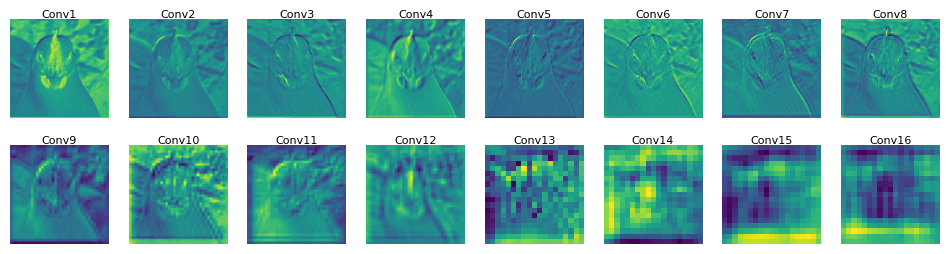

In [58]:
fig = plt.figure(figsize=(12, 3))
for i in range(1, len(processed)):
    a = fig.add_subplot(2, 8, i)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title('Conv'+str(i), fontsize=8, pad=1.2)
plt.savefig('feature_map.pdf',
            dpi = 600,
            bbox_inches = 'tight')

torch.Size([64, 150, 150])


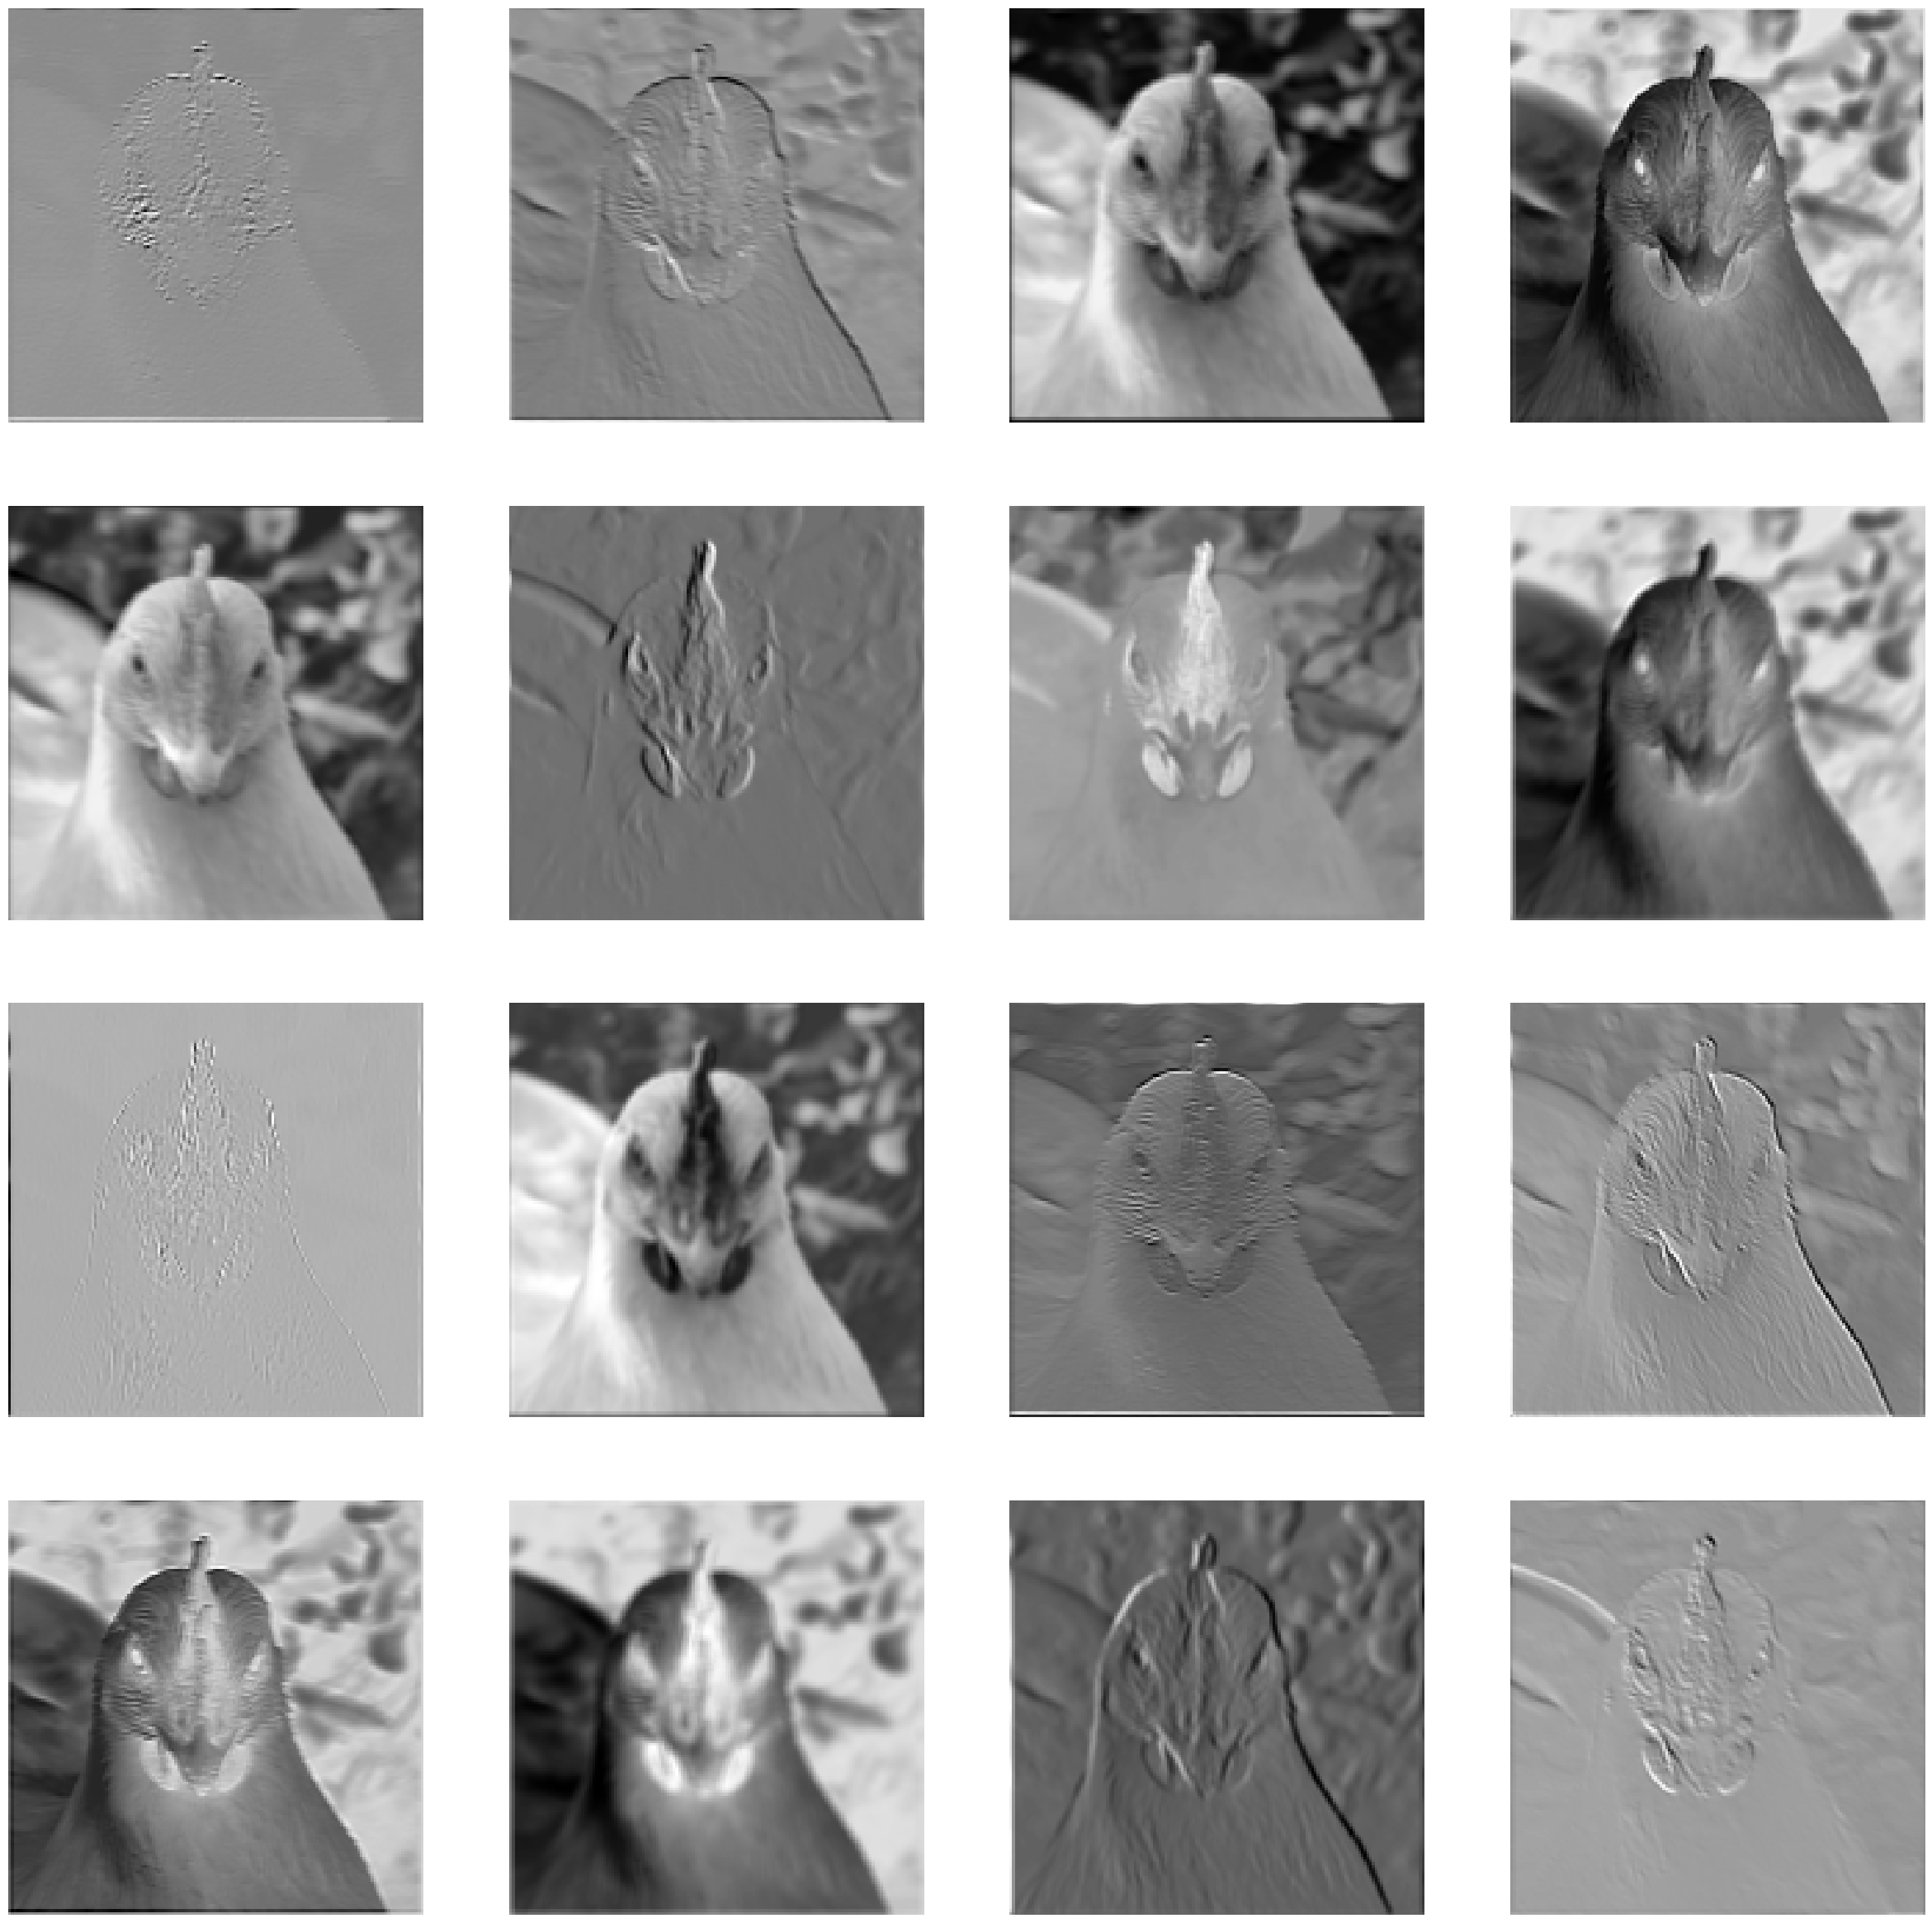

In [59]:
num_layer = 0
plt.figure(figsize=(30, 30))
layer_viz = outputs[num_layer][0, :, :, :]
layer_viz = layer_viz.data
print(layer_viz.size())
for i, filter in enumerate(layer_viz):
    if i == 16:
        break
    plt.subplot(4, 4, i + 1)
    plt.imshow(filter.detach().cpu(), cmap='gray')
    plt.axis("off")
plt.savefig('layer_{}.pdf'.format(num_layer),
        dpi = 600,
        bbox_inches = 'tight')

torch.Size([128, 75, 75])


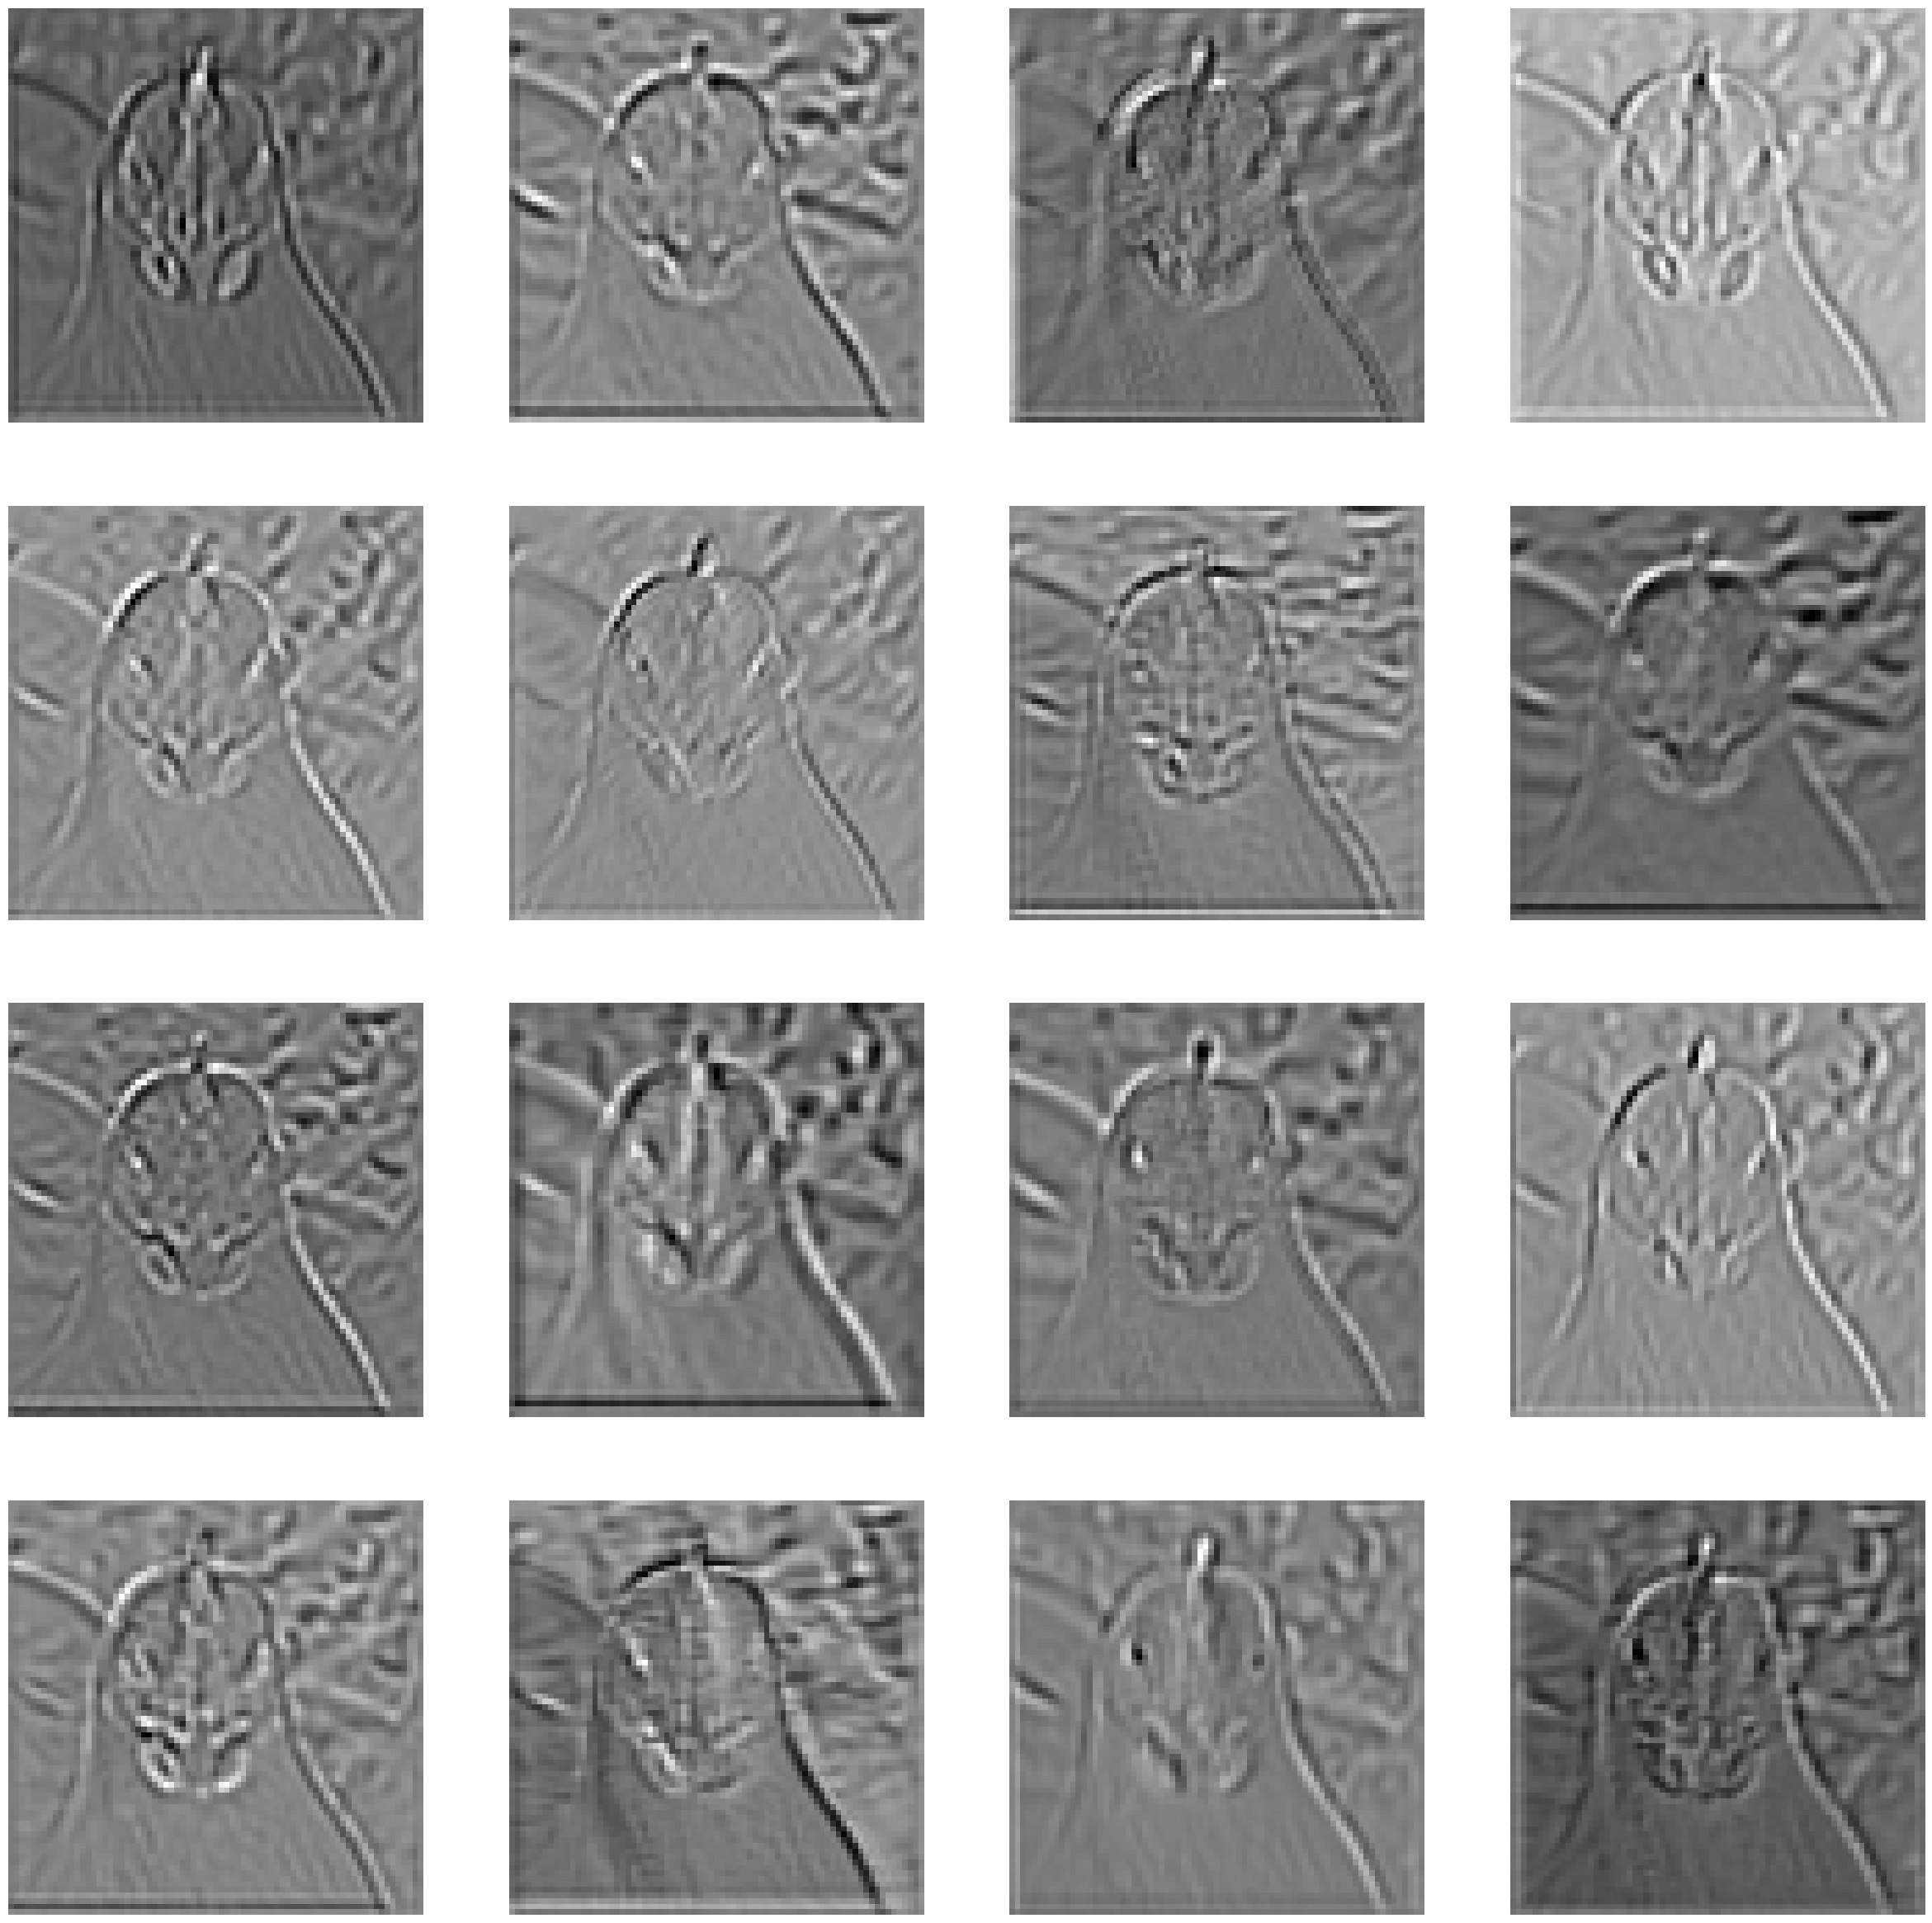

In [61]:
num_layer = len(outputs) // 2
plt.figure(figsize=(30, 30))
layer_viz = outputs[num_layer][0, :, :, :]
layer_viz = layer_viz.data
print(layer_viz.size())
for i, filter in enumerate(layer_viz):
    if i == 16:
        break
    plt.subplot(4, 4, i + 1)
    plt.imshow(filter.detach().cpu(), cmap='gray')
    plt.axis("off")
plt.savefig('layer_{}.pdf'.format(num_layer),
        dpi = 600,
        bbox_inches = 'tight')

torch.Size([512, 19, 19])


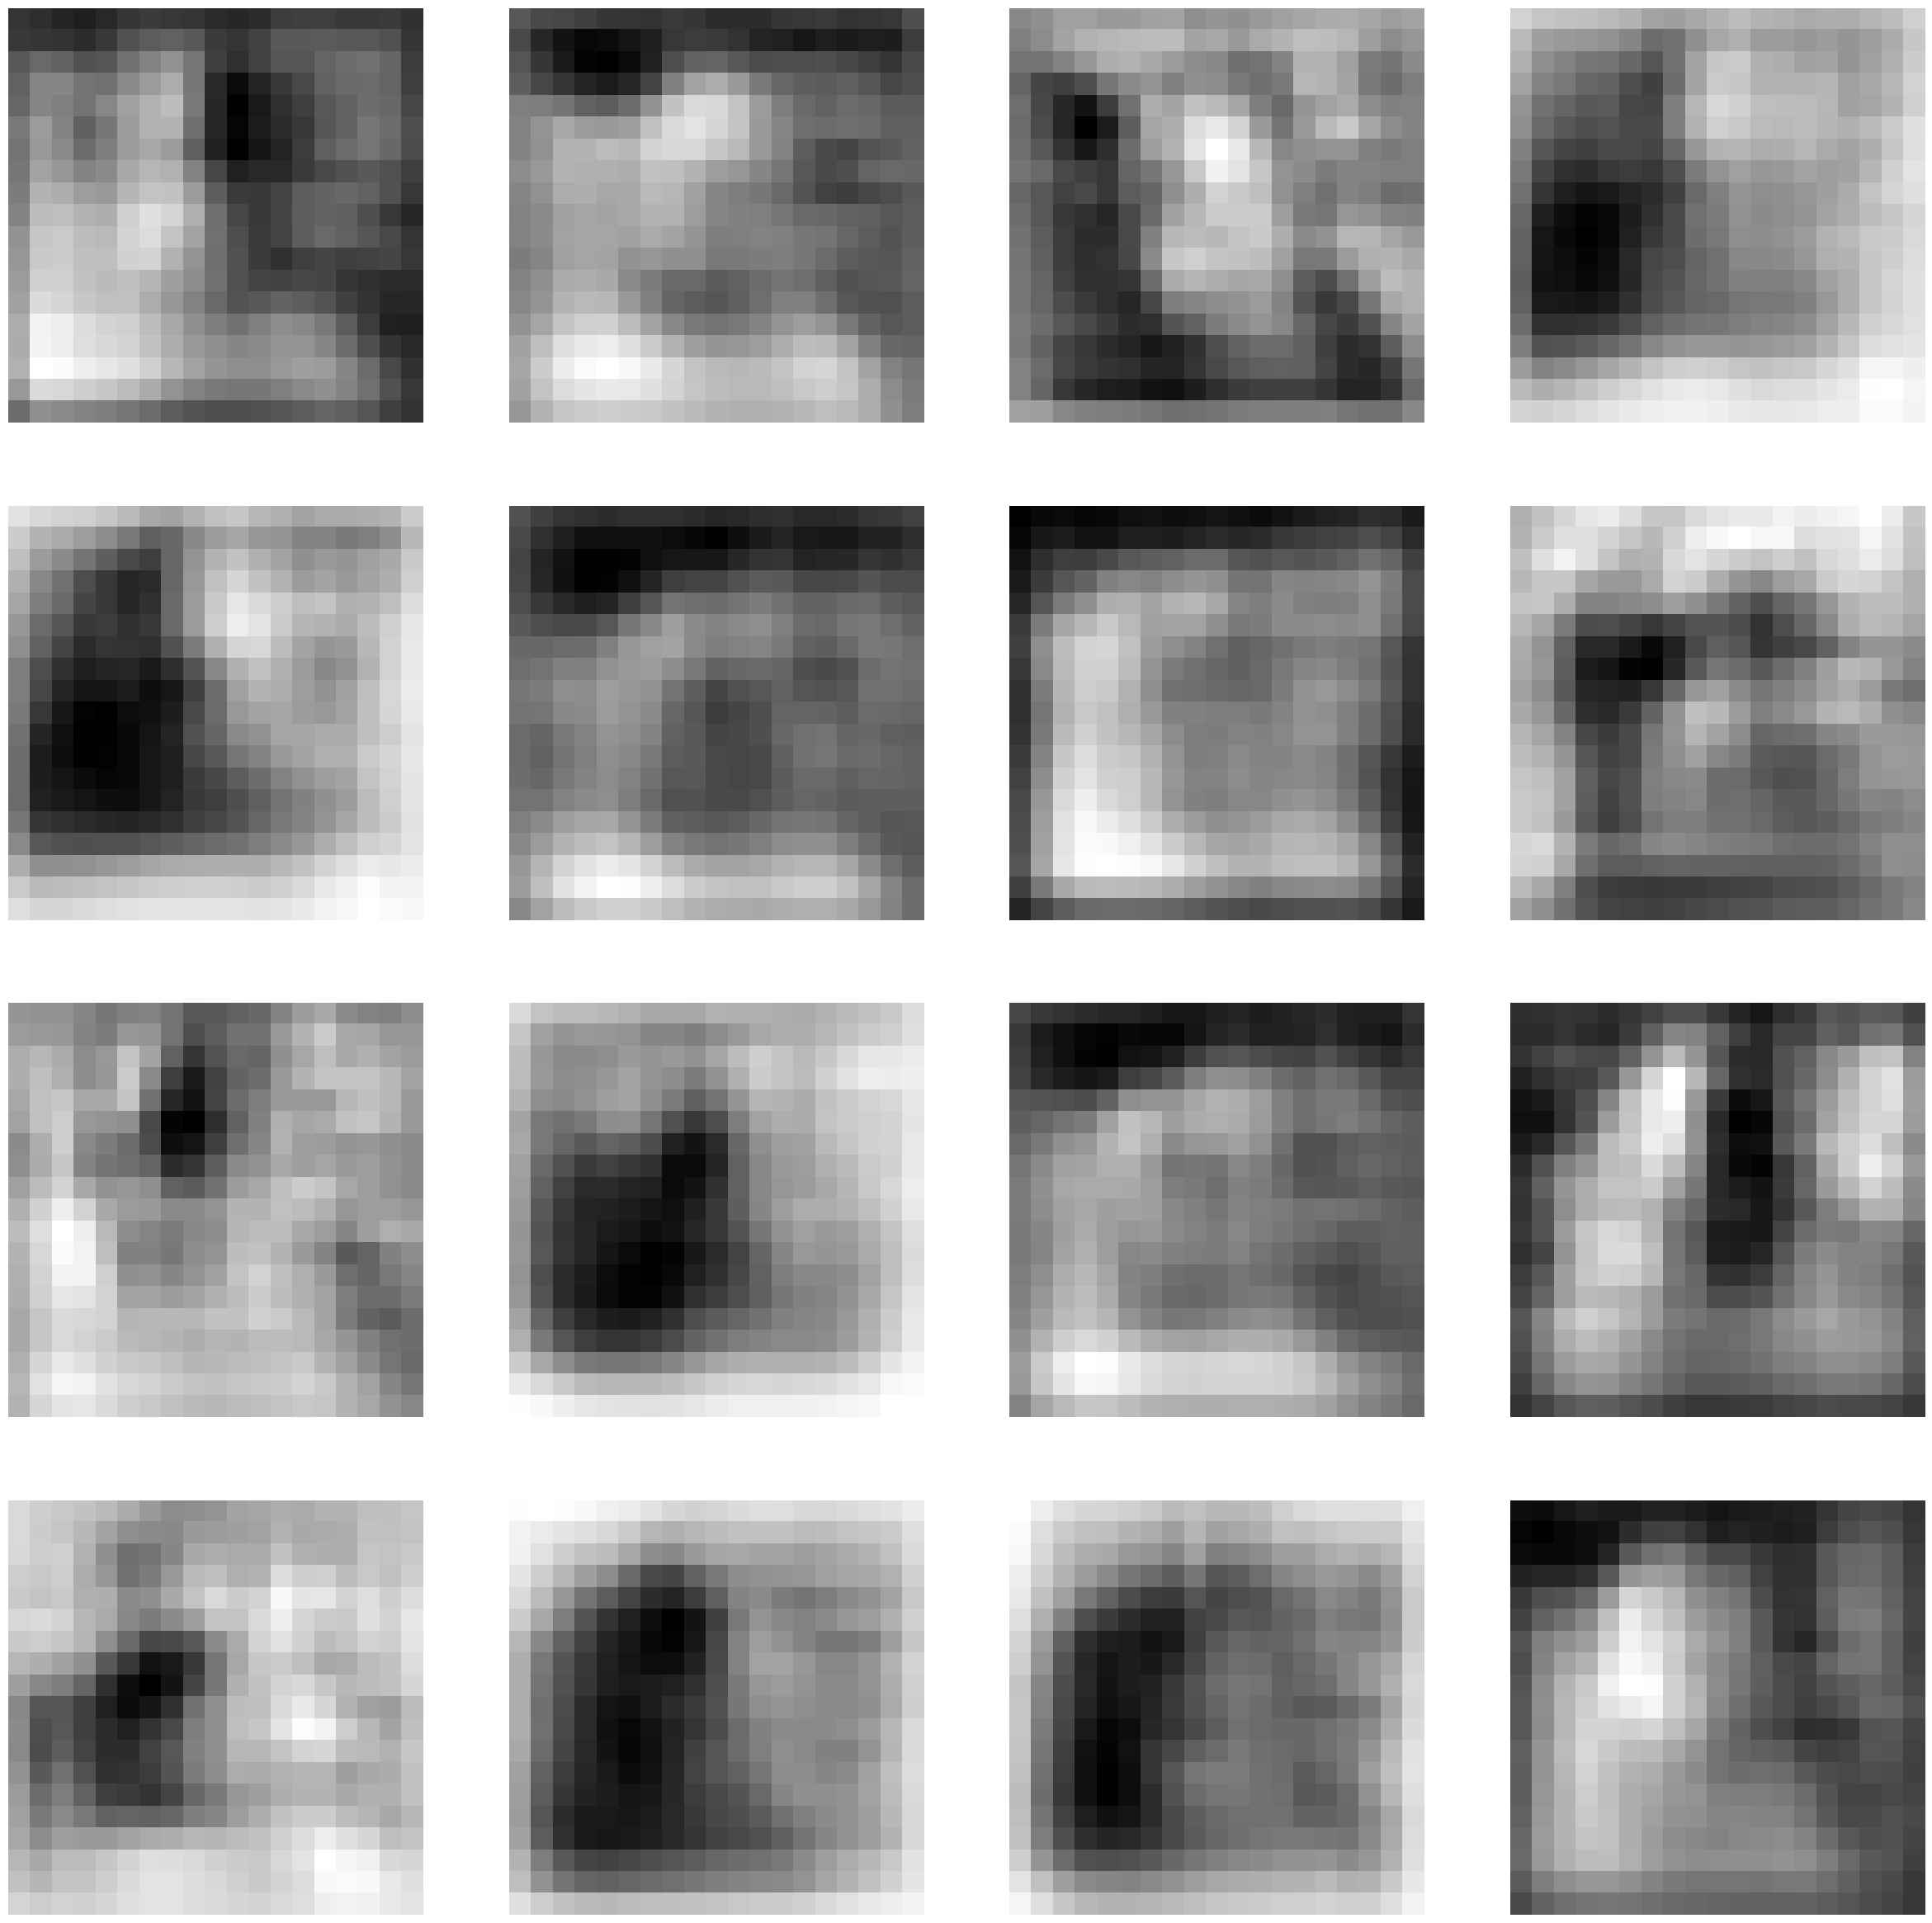

In [62]:
num_layer = len(outputs) - 1
plt.figure(figsize=(30, 30))
layer_viz = outputs[num_layer][0, :, :, :]
layer_viz = layer_viz.data
print(layer_viz.size())
for i, filter in enumerate(layer_viz):
    if i == 16:
        break
    plt.subplot(4, 4, i + 1)
    plt.imshow(filter.detach().cpu(), cmap='gray')
    plt.axis("off")
plt.savefig('layer_{}.pdf'.format(num_layer),
        dpi = 600,
        bbox_inches = 'tight')

In [34]:
upscaling_steps=13
opt_steps=20
verbose=1
TOP = 4

In [35]:
class SaveFeatures():
    def __init__(self, module, device=None):
        # we are going to hook some model's layer (module here)
        self.hook = module.register_forward_hook(self.hook_fn)
        self.device = device

    def hook_fn(self, module, input, output):
        # when the module.forward() is executed, here we intercept its
        # input and output. We are interested in the module's output.
        self.features = output.clone()
        if self.device is not None:
            self.features = self.features.to(device)
        self.features.requires_grad_(True)

    def close(self):
        # we must call this method to free memory resources
        self.hook.remove()

In [36]:
class FeatureMapVisualizer():
    def __init__(self, cnn, device, channels=3, layers_base=None, norm=None, denorm=None, save=None):
        self.model = cnn

        if layers_base is None:
            self.layers = self.model
        else:
            self.layers = layers_base
        
        self.channels = channels
        self.device = device

        mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
        std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)
            
        self.norm = norm
        self.denorm = denorm

        if norm is None:
            self.norm = transforms.Normalize(mean=mean.tolist(), std=std.tolist())

        if denorm is None:
            self.denorm = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
            
        self.save = save

    def set_layers_base(self, layers):
        # sometime we want to access to layers in deeper levels
        # so we could call something like:
        # featureMap.set_layers_base([module for module in model.children()][5][1])
        self.layers = layers
        
    def optimize_img(self, activations, filter, img, learning_rate, opt_steps, verbose):
        
        size = img.shape[1]
        img = torch.from_numpy(img.astype(np.float32).transpose(2,0,1))
        
        img = self.norm(img).double()
        img_input = img.clone().detach().reshape(1, self.channels, size, size).to(self.device).requires_grad_(True)
        optimizer = torch.optim.Adam([img_input], lr=learning_rate, weight_decay=1e-6)

        for n in range(opt_steps):
            optimizer.zero_grad()
            self.output = self.model(img_input)
            # TODO: the idea is to find an input image that
            #       'illuminate' ONLY ONE feature map (filter here)
            # TODO: 1 test a loss function that punish current
            #       activation filter with the rest of the
            #       filters mean values in the layer
            # TODO: 2 test a loss function that punish current activation
            #       filter with all the rest of the filters mean value
            #       of more layers (all?)
            loss = -1 * activations.features[0, filter].mean()
            loss.backward()
            if verbose > 1:
                print('.', end='')
            #print(loss.clone().detach().cpu().item())
            optimizer.step()
        if verbose > 1:
            print()
        img = self.denorm(img_input.clone().detach()[0].type(torch.float32))
        img = img.cpu().numpy().transpose(1,2,0)
        return img
        

    def visualize(self, layer, filter, size=56, upscaling_steps=12, upscaling_factor=1.2, lr=0.1, opt_steps=20, blur=None, verbose=2):
        training = self.model.training
        self.model.eval()
        self.model = self.model.double().to(self.device)
        # generate random image
        img = np.uint8(np.random.uniform(100, 160, (size, size, self.channels)))/255
        # register hook
        activations = SaveFeatures(self.layers[layer], self.device)
        if verbose > 0:
            print('Processing filter {}...'.format(filter))

        for i in range(upscaling_steps):
            if verbose > 1:
                print('{:3d} x {:3d}'.format(size,size), end='')

            img = self.optimize_img(activations, filter, img, learning_rate=lr, opt_steps=opt_steps, verbose=verbose)

            if i < upscaling_steps-1:
                size = int(size*upscaling_factor)
                # scale image up
                img = cv2.resize(img, (size, size), interpolation = cv2.INTER_CUBIC)
                # blur image to reduce high frequency patterns
                if blur is not None: img = cv2.blur(img,(blur,blur))
            img = np.clip(img, 0, 1)

        if verbose > 0:
            print('preparing image...')
        activations.close()
        self.model.train(training)
        if self.save != None:
            self.save("layer_{:02d}_filter_{:03d}.jpg".format(layer, filter), img)
        return img
    
    # We return the mean of every activation value, but this could
    # be other metric based on convolutional output values.
    def get_activations(self, monitor, input, mean=True):

        training = self.model.training
        self.model.eval()
        self.model = self.model.double().to(self.device)

        activations = {}
        mean_acts = {}

        print('hooking layers {}'.format(monitor))
        for layer in monitor:
            activations[layer] = SaveFeatures(self.layers[layer], device=self.device)

        self.output = self.model(input.to(self.device))

        for layer in activations.keys():
            filters = activations[layer].features.size()[1]
            mean_acts[layer] = [activations[layer].features[0,i].mean().item() for i in range(filters)]

        print('unhooking layers.')        
        for layer in activations.keys():
            activations[layer].close()
            
        self.model.train(training)
        
        if mean:
            return mean_acts
        
        return activations

In [44]:
model = models.vgg19_bn(weights='VGG19_BN_Weights.IMAGENET1K_V1')
model.eval()
layers = [layer for layer in model.children()]

In [45]:
monitor = [i for i, layer in enumerate(layers[0]) if isinstance(layer, torch.nn.ReLU)]

mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)

normalize = transforms.Normalize(mean=mean.tolist(), std=std.tolist())
denormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

img2tensor = transforms.Compose([transforms.Resize((229,229)), transforms.ToTensor(), normalize])

In [40]:
def show_filters(mean_act, filter, layer=None):
    filters = len(mean_act)
    plt.figure(figsize=(16,6))
    extraticks=[filter]
    act = plt.bar(list(range(filters)), mean_act)
    ax = act[0].axes
    ax.set_xticks([0,int(filters/2),filters] + extraticks)
    ax.set_xlim(0,filters)
    ax.plot(filter, mean_act[filter], 'ro')
    plt.axvline(x=filter, color='grey', linestyle='--')
    ax.set_xlabel("feature map")
    ax.set_ylabel("mean activation")
    if layer is not None:
        ax.set_title('Features maps of layer {}'.format(layer))
    plt.show()

In [48]:
fmv = FeatureMapVisualizer(model, device, layers_base=layers[0], save=None)

steps = 15
if str(device) == 'cpu': steps = 5
    
activation1_img = fmv.visualize(
                            layer=48, filter=91, size=56,
                            upscaling_steps=steps, opt_steps=20, blur=3, verbose=2
                        )
plt.imsave('activation1.jpg', activation1_img)

Processing filter 91...
 56 x  56....................
 67 x  67....................
 80 x  80....................
 96 x  96....................
115 x 115....................
138 x 138....................
165 x 165....................
198 x 198....................
237 x 237....................
284 x 284....................
340 x 340....................
408 x 408....................
489 x 489....................
586 x 586....................
703 x 703....................
preparing image...
